In [1]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import xarray as xr 
import pandas as pd 
import glob


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1313622976.py:17: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_50m = xr.open_rasterio(fn).rio.reproject('epsg:4326')
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1313622976.py:150: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,

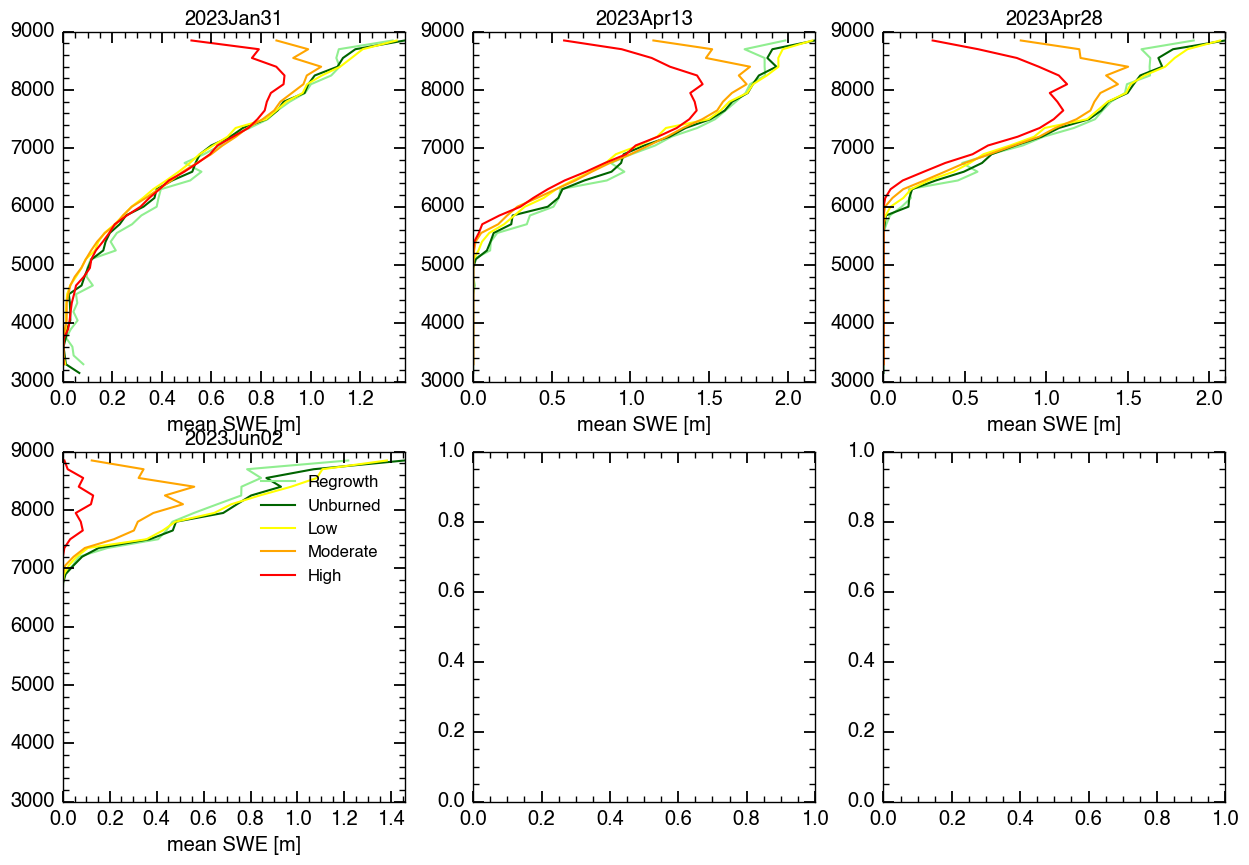

In [53]:

plt.style.use('/Users/cowherd/Documents/mplstyles/marianne.mplstyle')
datadir = '/Users/cowherd/Documents/ASO/'
fns = glob.glob(f'{datadir}*/*American*/*.tif')
dates23 = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02'] # , '2024Feb11-12']
dates24 = ['2024Feb11-12', '2024Apr10', '2024Apr30'] # , '2024Feb11-12']

vars50 = ['NIRalbedo_50m','BBalbedo_50m', 'snowdepth_50m', 'swe_50m']
vars3 = ['snowdepth_3m', 'swe_3m']
projdir = '/Users/cowherd/Documents/caldor-snow/'
caldor = gpd.read_file(f'{projdir}/data/caldor.shp')
caldor = caldor.to_crs('epsg:4326') 
srtm = xr.open_dataarray('../data/srtm30_sfa.nc')
cldrstr = 'ca3858612053820210815'
cldrdate= '20210805_20220723'
mtbs_rdnbr = xr.open_dataset(f'{projdir}/data/{cldrstr}/{cldrstr}_{cldrdate}_rdnbr.tif')
fn = glob.glob(f'{datadir}*American*/*American*{dates23[0]}*{vars50[-1]}.tif')[0]
ds_50m = xr.open_rasterio(fn).rio.reproject('epsg:4326')
srtm = srtm.rio.write_crs('epsg:4326').rename({'lat':'y','lon':'x'})
srtm_50 = srtm.rio.reproject_match(ds_50m)

slope_data = np.arctan(np.sqrt(np.gradient(srtm_50.values, axis=0)**2 + np.gradient(srtm_50.values, axis=1)**2))

# Create a new xarray dataset for the slope
slope_da = xr.DataArray(slope_data, coords=srtm_50.coords, dims=srtm_50.dims, name='slope')

# Create an xarray dataset for the slope
slope_50 = xr.Dataset({'slope': np.degrees(slope_da)})
grad_x = np.gradient(srtm_50, axis=0)
grad_y = np.gradient(srtm_50, axis=1)
aspect_data = np.arctan2(-grad_x, grad_y) * 180 / np.pi  # Convert to degrees

# Create a new xarray dataset for the aspect
aspect_da = xr.DataArray(aspect_data, coords=srtm_50.coords, dims=srtm_50.dims)

# Create an xarray dataset for the aspect
aspect_50 = xr.Dataset({'aspect': aspect_da})



mtbs_rdnbr_50 = mtbs_rdnbr.rio.reproject_match(ds_50m)

import matplotlib.pyplot as plt

band_size = 150

def get_elev(ds_50, srtm_50, STATIC = False):
    # Extract elevation values from 'srtm_50' dataset
    elevation_values = srtm_50.values
    elevation_values_ft = elevation_values * 3.28084
    # Extract values from 'ds_50m' dataset
    ds_values = ds_50[0].values

    # Calculate the elevation bands
    elevation_bands = np.arange(1500, np.nanmax(elevation_values_ft), band_size)
    if STATIC:
        elevation_bands = np.arange(1500, 9000, band_size)

    # Initialize lists to store the means and percentiles
    band_means = []
    percentiles_25 = []
    percentiles_75 = []
    stds = []

    # Loop through elevation bands and calculate statistics for each band
    for band in elevation_bands:
        mask = (elevation_values_ft >= band) & (elevation_values_ft < band + band_size)
        values_in_band = ds_values[mask]
        if len(values_in_band) > 0:
            band_means.append(np.nanmedian(values_in_band))
            percentiles_25.append(np.nanpercentile(values_in_band, 25))
            percentiles_75.append(np.nanpercentile(values_in_band, 75))
            stds.append(np.nanstd(values_in_band))
        else:
            band_means.append(0)
            percentiles_25.append(0)
            percentiles_75.append(0)
            stds.append(0)

    return elevation_bands, band_means, percentiles_25, percentiles_75, stds

def get_elev_aspect_grid(ds_50, srtm_50, aspect_50, STATIC = False, ebin_size = 200, abin_size = 45/2):
    # Extract elevation values from 'srtm_50' dataset
    elevation_values = srtm_50.values
    elevation_values_ft = elevation_values * 3.28084
    aspect_values = aspect_50.values
    # Extract values from 'ds_50m' dataset
    ds_values = ds_50[0].values


    # Calculate the elevation bands
    elevation_bands = np.arange(1500, np.nanmax(elevation_values_ft), ebin_size)
    if STATIC:
        elevation_bands = np.arange(1500, 9000, ebin_size)

    aspect_bands = np.arange(-180, 180+abin_size, abin_size)

    # Initialize lists to store the means and percentiles
    band_means = np.zeros((len(elevation_bands), len(aspect_bands)))
    counts = np.zeros((len(elevation_bands), len(aspect_bands)))

    percentiles_25 = []
    percentiles_75 = []

    # Loop through elevation bands and calculate statistics for each band
    for i,eband in enumerate(elevation_bands):
        for j,aband in enumerate(aspect_bands):
            mask = (elevation_values_ft >= eband) & (elevation_values_ft < eband + ebin_size) & (aspect_values >= aband) & (aspect_values < aband + abin_size)
            values_in_band = ds_values[mask]
            if len(values_in_band) > 0:
                band_means[i,j] = np.nanmean(values_in_band)
                counts[i,j] = np.nansum(~np.isnan(values_in_band.flatten()))
                percentiles_25.append(np.nanpercentile(values_in_band, 25))
                percentiles_75.append(np.nanpercentile(values_in_band, 75))
            else:
                band_means[i,j] = np.nan
                counts[i,j] = 0
                percentiles_25.append(np.nan)
                percentiles_75.append(np.nan)

    return elevation_bands, aspect_bands, band_means, counts # , percentiles_25, percentiles_75



categories = ["Regrowth", "Unburned", "Low", "Moderate", "High"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red"]
# Define the burn severity categories and their cutoff values
bounds = [-5000, -100, 70, 315, 640, 5000]

# Create an empty dictionary to store masks for each category
category_masks = {}

# Create masks for each category
for i in range(len(bounds) - 1):
    lower_bound = bounds[i]
    upper_bound = bounds[i + 1]
    category_label = categories[i]

    # Create a mask for the current category
    mask = (mtbs_rdnbr_50 >= lower_bound) & (mtbs_rdnbr_50 < upper_bound)

    # Add the mask to the dictionary with the category label as the key
    category_masks[category_label] = mask


fig, axs = plt.subplots(2,3,figsize=(15, 10))
axs = axs.flatten()
for i,date in enumerate(dates23):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    inside = ds.rio.clip(caldor.geometry, invert = False)
    outside = ds.rio.clip(caldor.geometry, invert = True)
    srtm_50_out = srtm_50.rio.clip(caldor.geometry, invert = True)
    srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert = False)
    
    for j, category in enumerate(categories):
        category_mask = category_masks[category]['band_data'][0].rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(category_mask)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        ax.plot(band_means, elevation_bands, label=category, linestyle='-', color=colors[j])

    ax.set_title(date)
    ax.set_xlabel('mean SWE [m]')
    ax.set_label('Elevation [ft]')
    ax.set_ylim((3000,9000))
ax.legend()

plt.show()


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/202595915.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/202595915.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/202595915.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/202595915.py:6: DeprecationWa

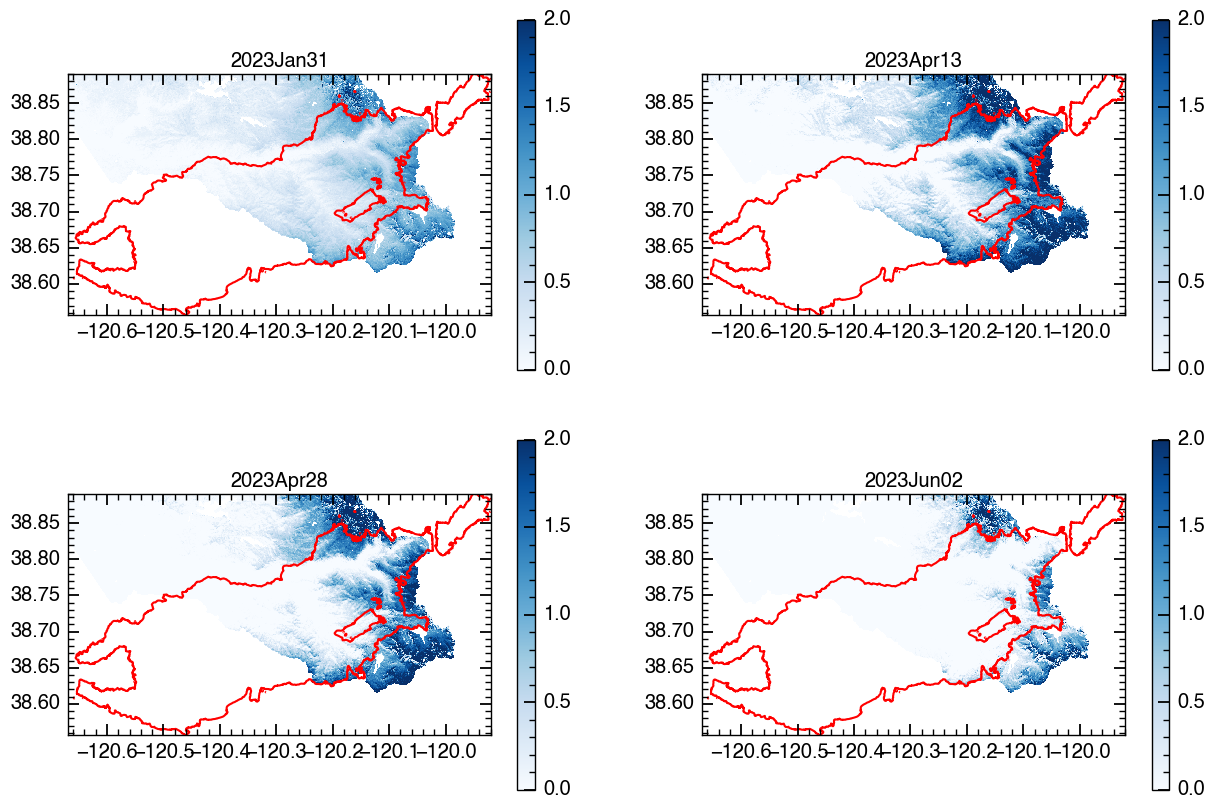

In [5]:
fig, ax = plt.subplots(2,2,figsize=(15, 10))
axs = ax.flatten()
for i,date in enumerate(dates23):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    cb = ax.pcolormesh(ds.x, ds.y, ds[0], cmap='Blues', vmin = 0, vmax = 2)
    caldor.boundary.plot(ax=ax, edgecolor='red')
    ax.set_xlim((caldor.bounds.minx[0], caldor.bounds.maxx[0]))
    ax.set_ylim((caldor.bounds.miny[0], caldor.bounds.maxy[0]))
    ax.set_title(date)
    plt.colorbar(cb, ax=ax)
plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/4002502242.py:7: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1313622976.py:110: RuntimeWarning: Mean of empty slice
  band_means[i,j] = np.nanmean(values_in_band)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1313622976.py:110: RuntimeWarning: Mean of empty slice
  band_means[i,j] = np.nanmean(values_in_band)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95l

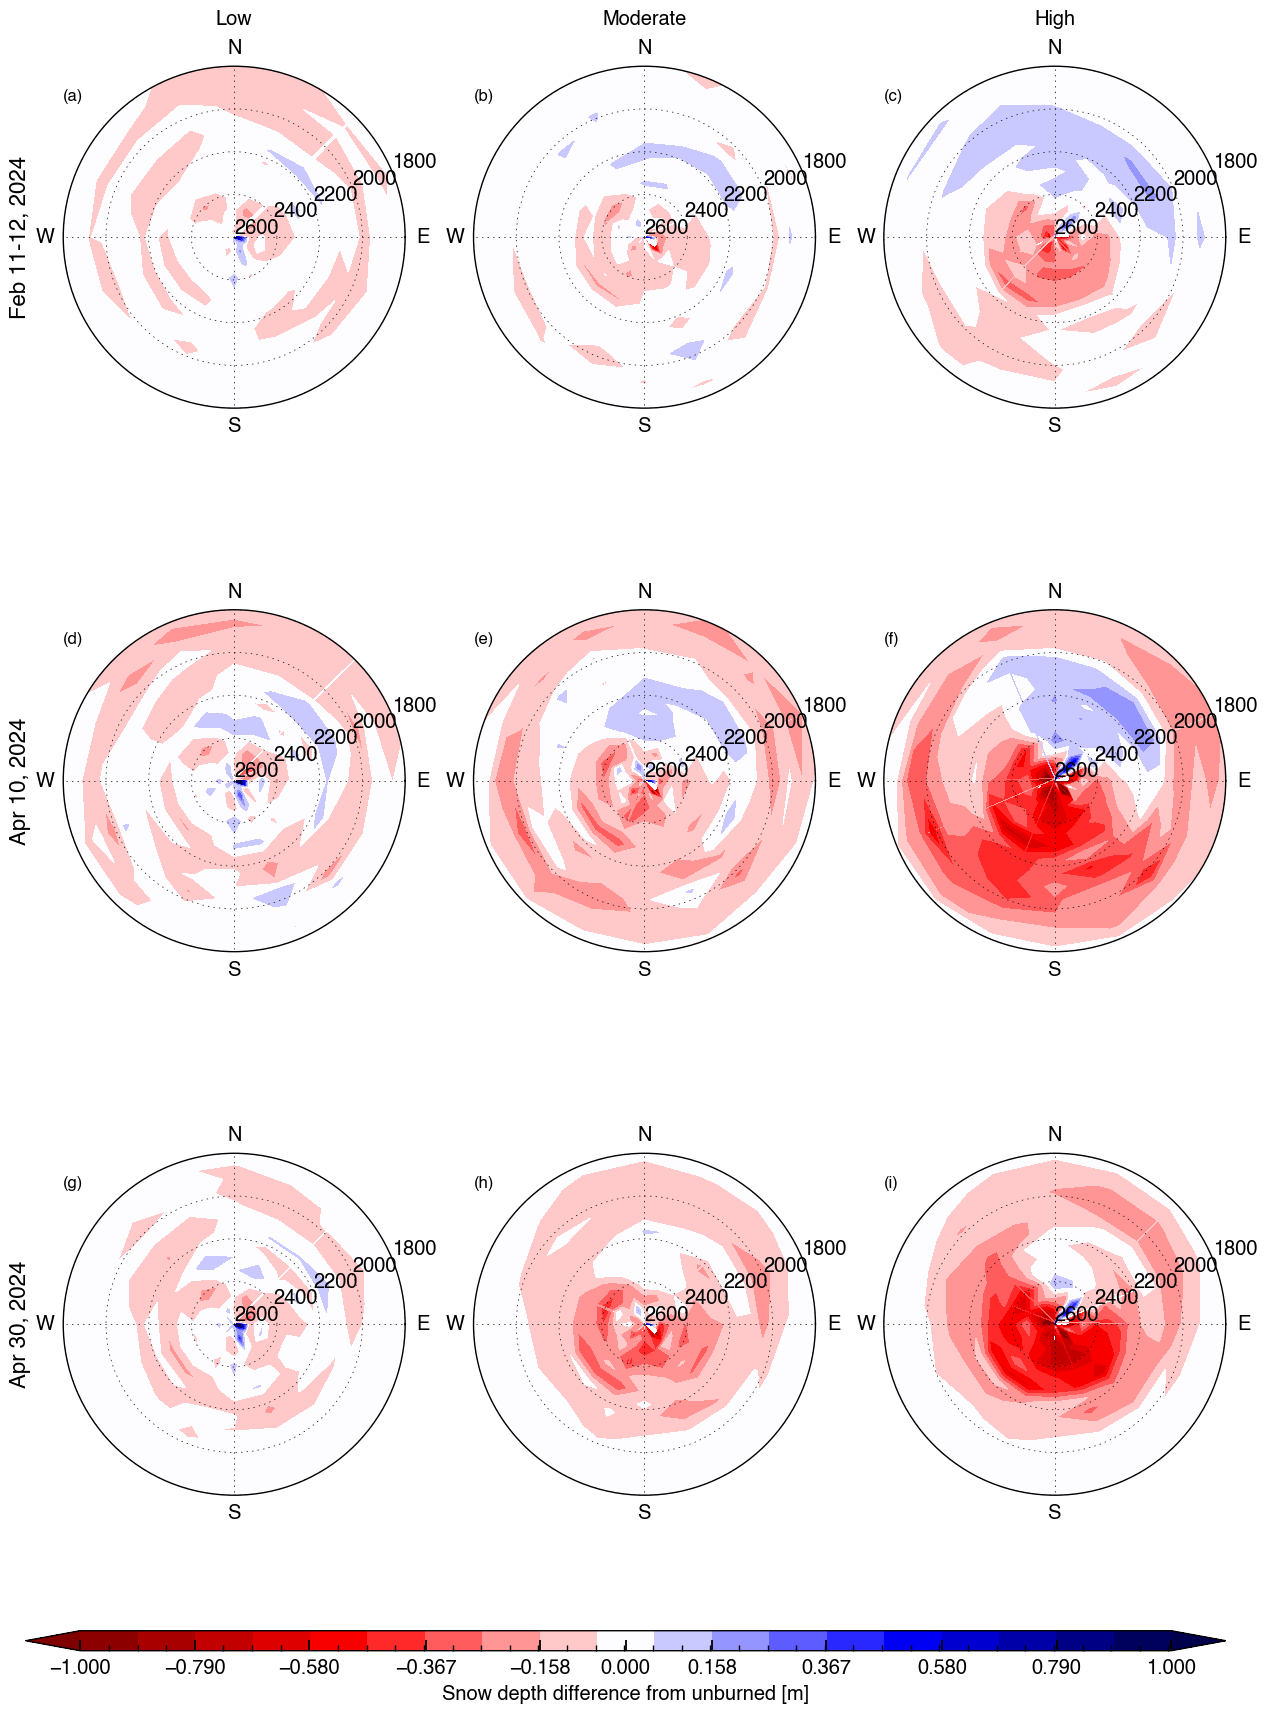

In [54]:
category_grids_depth = {}
elev_bands_depth= {}

for i, date in enumerate(dates24 + dates23):
    category_grids_depth[date] = {}
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    inside = ds.rio.clip(caldor.geometry, invert=False)
    outside = ds.rio.clip(caldor.geometry, invert=True)
        
    for j, category in enumerate(categories):
        category_mask = category_masks[category]['band_data'][0].rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(category_mask)
        inside_category = inside_category.where(inside_category >= 0)  # Remove negative values
        aspect_50_in = aspect_50.aspect.rio.clip(caldor.geometry, invert=False).where(category_mask)
        srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert=False).where(category_mask)

        elev_bands_depth, aspect_bands, elev_aspect_cat, counts_in = get_elev_aspect_grid(inside_category, srtm_50_in, aspect_50_in, STATIC=True)
        category_grids_depth[date][category] = elev_aspect_cat

cat1 = 'Unburned'
aspect_theta = np.radians(aspect_bands) + np.pi
radii = elev_bands_depth
radii_m = elev_bands_depth * 0.3048
aspect_theta_2 = [0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
       3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
       5.89048623, 6.28318531]

fig, axs = plt.subplots(3,3, figsize=(15, 20), subplot_kw={'projection': 'polar'}) # ,gridspec_kw = {'height_ratios':[1, 1, 1, 1, 0.2]})
cbar_ax = fig.add_axes([0.1,0.06,0.8,0.01], ) # [left, bottom, width, height]
for id,date in enumerate(dates24):
    in_grids = category_grids_depth[date]
    
    axs[id,0].text(np.pi, 1600, f'{date[4:7]} {date[7:]}, {date[0:4]}', ha='center', va='center', fontsize=16, color='black', rotation = 90)
    
    for i, cat2 in enumerate(['Low','Moderate','High']):
        ax = axs[id,i]
        # ax.contourf(aspect_theta, radii, np.isnan(in_grids[cat2] - in_grids[cat1] ), cmap='Greys', vmin=-1, vmax=1)
        data = in_grids[cat2] - in_grids[cat1]
        data2 = np.zeros((len(radii), len(aspect_theta_2)))
        data2[:,0:17] = data
        data2[:,16] = data[:,0]
        cb = ax.contourf(aspect_theta_2, radii_m ,data2, cmap='seismic_r',  levels = np.linspace(-1, 1, 20), extend = 'both')

        # cb = ax.contourf(aspect_theta, radii,data, cmap='seismic_r', vmin=-1, vmax=1, levels = np.linspace(-1, 1, 20), extend = 'both')

        ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
        ax.set_xticklabels(['E', 'N', 'W', 'S'])
        
        ax.set_yticks([1800, 2000, 2200, 2400, 2600])

        ax.set_ylim(2600, 1800)
        
        if id == 0:
            ax.set_title(cat2, pad = 30, loc='center')
            
#ticklist = list(np.arange(-1,1+2/21, 4/21))
#ticklist.append(0)
#ticklist.sort()

new_ticks = [-1, -0.79, -0.58, -0.367, -0.158, 0, 0.158, 0.367, 0.58,  0.79, 1]
# new_ticks = [v*2 for v in new_ticks]


cbar = fig.colorbar(cb, ticks=new_ticks,
                    cax=cbar_ax, orientation='horizontal', extend='both', label='Snow depth difference from unburned [m]')

for i,ax in enumerate(axs.flatten()):
    ax.text(0,.9,f'({chr(97+i)})', transform = ax.transAxes, weight = 'bold')
plt.savefig('../figures/caldor_snow_depth_diff_2024.png', dpi=600, bbox_inches='tight')
plt.show()


In [55]:
inside_category

<xarray.DataArray (band: 1, y: 546, x: 1373)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -120.7 -120.7 -120.7 ... -120.0 -120.0 -120.0
  * y            (y) float64 38.89 38.89 38.89 38.89 ... 38.61 38.61 38.61 38.61
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0

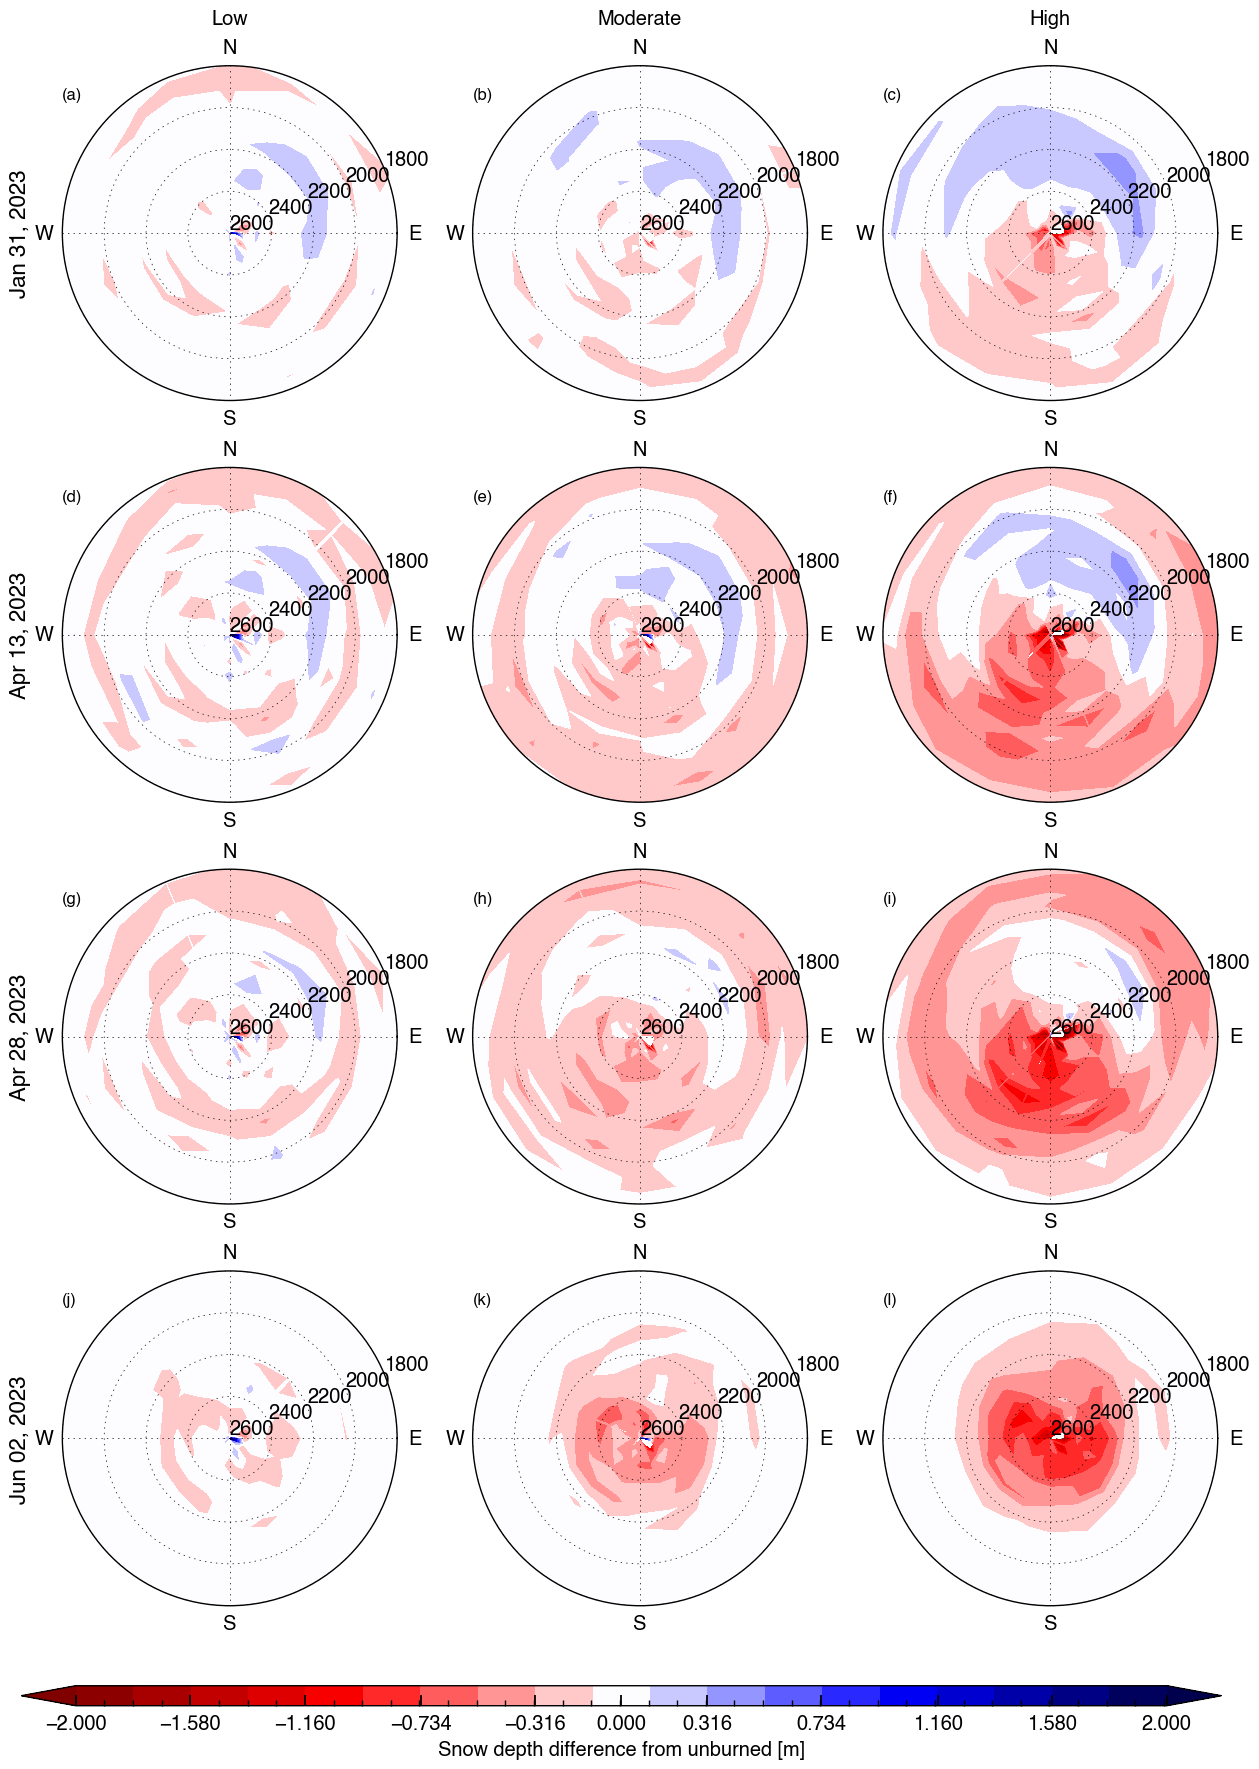

In [11]:
aspect_theta = np.radians(aspect_bands) + np.pi
radii = elev_bands_depth
radii_m = elev_bands_depth * 0.3048
aspect_theta_2 = [0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
       3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
       5.89048623, 6.28318531]

fig, axs = plt.subplots(4,3, figsize=(15, 20), subplot_kw={'projection': 'polar'}) # ,gridspec_kw = {'height_ratios':[1, 1, 1, 1, 0.2]})
cbar_ax = fig.add_axes([0.1,0.06,0.8,0.01], ) # [left, bottom, width, height]
for id,date in enumerate(dates23):
    in_grids = category_grids_depth[date]
    
    axs[id,0].text(np.pi, 1600, f'{date[4:7]} {date[7:]}, {date[0:4]}', ha='center', va='center', fontsize=16, color='black', rotation = 90)
    
    for i, cat2 in enumerate(['Low','Moderate','High']):
        ax = axs[id,i]
        # ax.contourf(aspect_theta, radii, np.isnan(in_grids[cat2] - in_grids[cat1] ), cmap='Greys', vmin=-1, vmax=1)
        data = in_grids[cat2] - in_grids[cat1]
        data2 = np.zeros((len(radii), len(aspect_theta_2)))
        data2[:,0:17] = data
        data2[:,16] = data[:,0]
        cb = ax.contourf(aspect_theta_2, radii_m ,data2, cmap='seismic_r',  levels = np.linspace(-2, 2, 20), extend = 'both')

        # cb = ax.contourf(aspect_theta, radii,data, cmap='seismic_r', vmin=-1, vmax=1, levels = np.linspace(-1, 1, 20), extend = 'both')

        ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
        ax.set_xticklabels(['E', 'N', 'W', 'S'])
        
        ax.set_yticks([1800, 2000, 2200, 2400, 2600])

        ax.set_ylim(2600, 1800)
        
        if id == 0:
            ax.set_title(cat2, pad = 30, loc='center')
            

new_ticks = [-1, -0.79, -0.58, -0.367, -0.158, 0, 0.158, 0.367, 0.58,  0.79, 1]
new_ticks = [v*2 for v in new_ticks]


cbar = fig.colorbar(cb, ticks=new_ticks,
                    cax=cbar_ax, orientation='horizontal', extend='both', label='Snow depth difference from unburned [m]')

for i,ax in enumerate(axs.flatten()):
    ax.text(0,.9,f'({chr(97+i)})', transform = ax.transAxes, weight = 'bold')
plt.savefig('../figures/elev-aspect-2023.jpg', dpi=800, bbox_inches='tight')
plt.show()


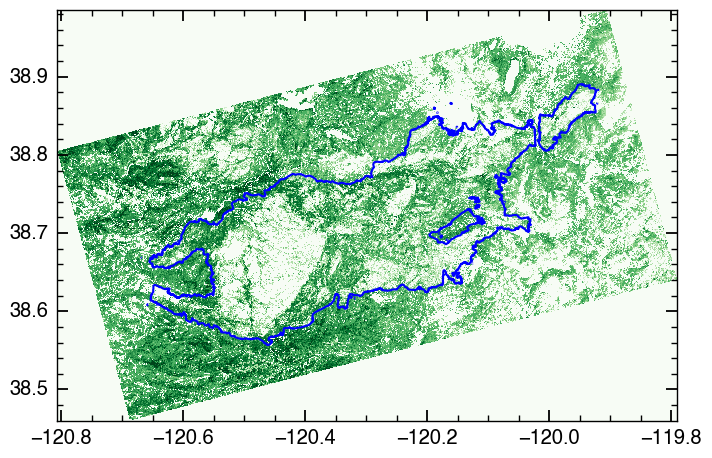

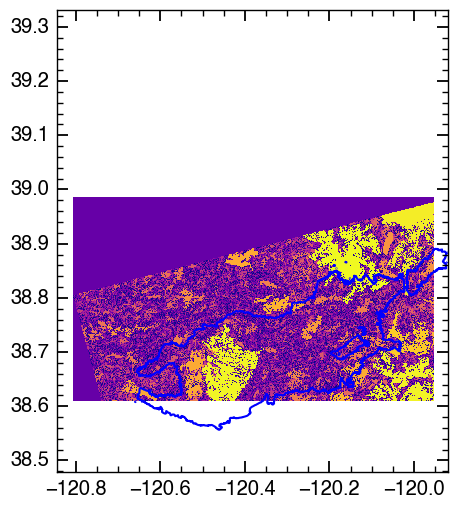

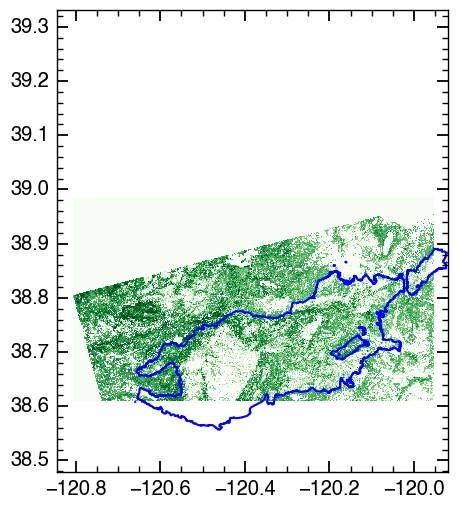

In [12]:
## now do it for canopy cover, not burn severity
ds = xr.open_dataset('../data/lfcc_area.nc')
fig, ax = plt.subplots()
ax.pcolormesh(ds.x, ds.y, ds.band_data, cmap = 'Greens')
caldor.boundary.plot(ax=ax)

plt.show()
ds = ds.rio.write_crs('epsg:4326')
band_data_rp = ds.band_data.rio.reproject_match(ds_50m)
log_area_rp =  ds.log_area.rio.reproject_match(ds_50m)
fig, ax = plt.subplots()
ax.pcolormesh(log_area_rp.x, log_area_rp.y, log_area_rp, cmap = 'plasma')
caldor.boundary.plot(ax=ax)

plt.show()

fig, ax = plt.subplots()
ax.pcolormesh(band_data_rp.x, band_data_rp.y, band_data_rp, cmap = 'Greens')
caldor.boundary.plot(ax=ax)
plt.show()

In [97]:
def get_elev_aspect_grid(ds_50, srtm_50, aspect_50, STATIC = False, ebin_size = 200, abin_size = 45/2):
    # Extract elevation values from 'srtm_50' dataset
    elevation_values = srtm_50.values
    elevation_values_ft = elevation_values * 3.28084
    aspect_values = aspect_50.values
    # Extract values from 'ds_50m' dataset
    ds_values = ds_50[0].values


    # Calculate the elevation bands
    if STATIC:
        elevation_bands = np.arange(1500, 9000, ebin_size)
    else:
        elevation_bands = np.arange(1500, np.nanmax(elevation_values_ft), ebin_size)


    aspect_bands = np.arange(-180, 180+abin_size, abin_size)

    # Initialize lists to store the means and percentiles
    band_means = np.zeros((len(elevation_bands), len(aspect_bands)))
    counts = np.zeros((len(elevation_bands), len(aspect_bands)))

    percentiles_25 = []
    percentiles_75 = []

    # Loop through elevation bands and calculate statistics for each band
    for i,eband in enumerate(elevation_bands):
        for j,aband in enumerate(aspect_bands):
            mask = (elevation_values_ft >= eband) & (elevation_values_ft < eband + ebin_size) & (aspect_values >= aband) & (aspect_values < aband + abin_size)
            values_in_band = ds_values[mask]
            if len(values_in_band) > 0:
                band_means[i,j] = np.nanmean(values_in_band)
                counts[i,j] = np.nansum(~np.isnan(values_in_band.flatten()))
                percentiles_25.append(np.nanpercentile(values_in_band, 25))
                percentiles_75.append(np.nanpercentile(values_in_band, 75))
            else:
                band_means[i,j] = np.nan
                counts[i,j] = 0
                percentiles_25.append(np.nan)
                percentiles_75.append(np.nan)

    return elevation_bands, aspect_bands, band_means, counts # , percentiles_25, percentiles_75


(array([658195.,      0.,  26976.,  80978., 117666.,      0., 178074.,
         99909.,  58840.,  11084.]),
 array([ 0. ,  7.5, 15. , 22.5, 30. , 37.5, 45. , 52.5, 60. , 67.5, 75. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

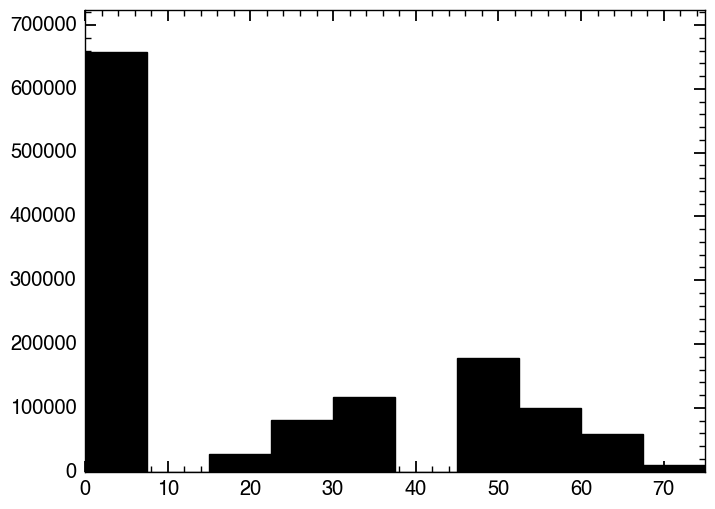

In [74]:
plt.hist(band_data_rp.values.flatten())

In [102]:
STATIC = True
ds_50 = inside_category
elevation_values = srtm_50_in

# Extract elevation values from 'srtm_50' dataset
elevation_values = srtm_50.values
elevation_values_ft = elevation_values * 3.28084
# Extract values from 'ds_50m' dataset
ds_values = ds_50[0].values

# Calculate the elevation bands
elevation_bands = np.arange(1500, np.nanmax(elevation_values_ft), band_size)
if STATIC:
    elevation_bands = np.arange(1500, 9000, band_size)

# Initialize lists to store the means and percentiles
band_means = []
percentiles_25 = []
percentiles_75 = []
stds = []

# Loop through elevation bands and calculate statistics for each band
for band in elevation_bands:
    mask = (elevation_values_ft >= band) & (elevation_values_ft < band + band_size)
    values_in_band = ds_values[mask]
    if len(values_in_band) > 0:
        band_means.append(np.nanmedian(values_in_band))
        percentiles_25.append(np.nanpercentile(values_in_band, 25))
        percentiles_75.append(np.nanpercentile(values_in_band, 75))
        stds.append(np.nanstd(values_in_band))
    else:
        band_means.append(0)
        percentiles_25.append(0)
        percentiles_75.append(0)
        stds.append(0)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 546 but corresponding boolean dimension is 1414

(546, 1373)

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1291067627.py:27: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = f

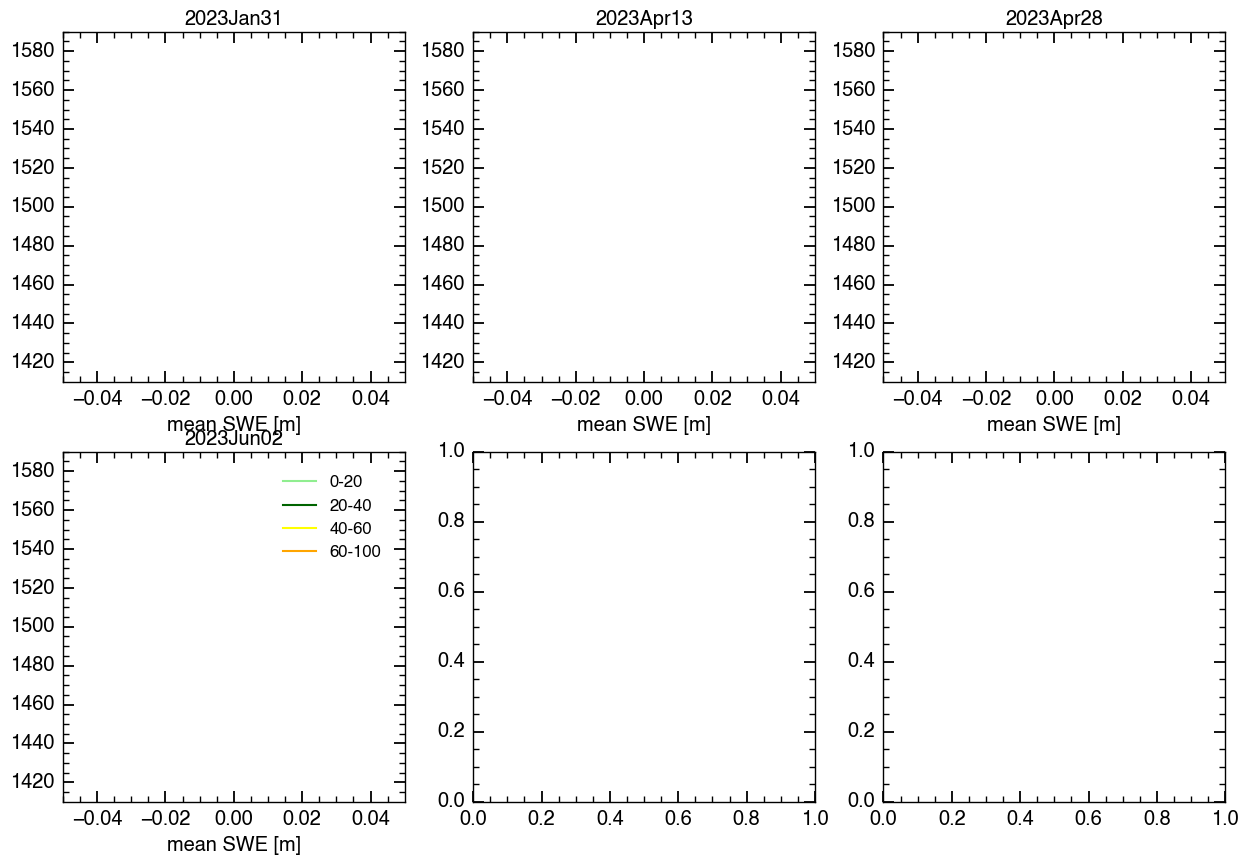

In [98]:
categories_forest = ["0-20", "20-40", "40-60", "60-100"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red"]
# Define the burn severity categories and their cutoff values
bounds = [-1, 21, 41, 61, 101]

# Create an empty dictionary to store masks for each category
category_masks_forest = {}

# Create masks for each category
for i in range(len(bounds) - 1):
    lower_bound = bounds[i]
    upper_bound = bounds[i + 1]
    category_label = categories_forest[i]

    # Create a mask for the current category
    mask = (band_data_rp >= lower_bound) & (band_data_rp < upper_bound)

    # Add the mask to the dictionary with the category label as the key
    category_masks_forest[category_label] = mask


fig, axs = plt.subplots(2,3,figsize=(15, 10))
axs = axs.flatten()
for i,date in enumerate(dates23):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    inside = ds.rio.clip(caldor.geometry, invert = False)
    outside = ds.rio.clip(caldor.geometry, invert = True)
    srtm_50_out = srtm_50.rio.clip(caldor.geometry, invert = True)
    srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert = False)
    
    for j, category in enumerate(categories_forest):
        category_mask = category_masks_forest[category]
       # .rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(category_mask).where(inside_category > -1)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        ax.plot(band_means, elevation_bands, label=category, linestyle='-', color=colors[j])

    ax.set_title(date)
    ax.set_xlabel('mean SWE [m]')
    ax.set_label('Elevation [ft]')
    # ax.set_ylim((3000,9000))
ax.legend()

plt.show()


In [114]:
inside.sel(band=1).shape

(546, 1373)

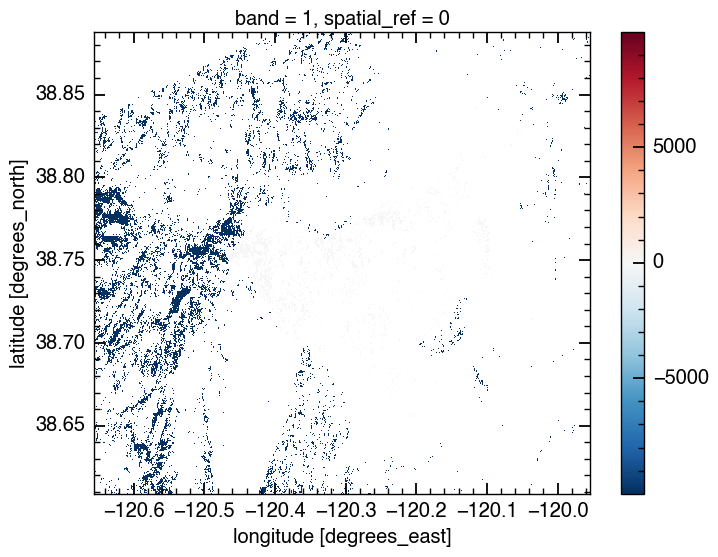

In [94]:
inside.where(category_mask).sel(band=1)

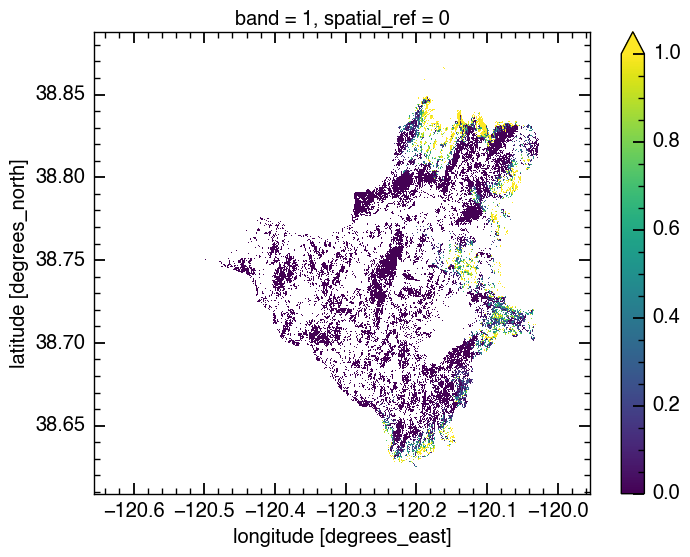

In [85]:
tmp = inside.sel(band=1).where(category_masks_forest['0-20'])
tmp = tmp.where(tmp >=0)
tmp.plot(vmin = 0, vmax = 1)

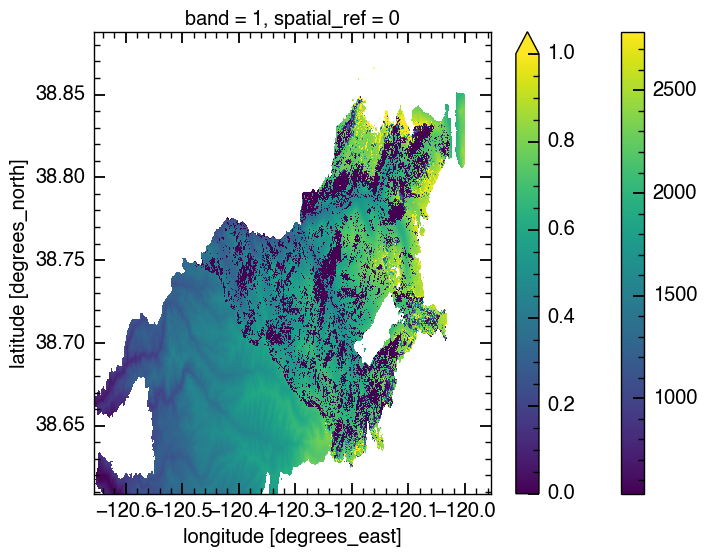

In [87]:
srtm_50_in.plot()
tmp.plot(vmin = 0, vmax = 1)

NameError: name 'elevation_values_ft' is not defined

In [59]:
category_grids_forest = {}
elev_bands_forest= {}

for i, date in enumerate(dates24 + dates23):
    category_grids_forest[date] = {}
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    inside = ds.rio.clip(caldor.geometry, invert=False)
    outside = ds.rio.clip(caldor.geometry, invert=True)
        
    for j, category in enumerate(categories_forest):
        category_mask = category_masks_forest[category].rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(category_mask)
        inside_category = inside_category.where(inside_category >= 0)  # Remove negative values
        aspect_50_in = aspect_50.aspect.rio.clip(caldor.geometry, invert=False).where(category_mask)
        srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert=False).where(category_mask)

        elev_bands_depth, aspect_bands, elev_aspect_cat, counts_in = get_elev_aspect_grid(inside_category, srtm_50_in, aspect_50_in, STATIC=True)
        category_grids_forest[date][category] = elev_aspect_cat


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/4167246783.py:7: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1313622976.py:110: RuntimeWarning: Mean of empty slice
  band_means[i,j] = np.nanmean(values_in_band)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_74967/1313622976.py:110: RuntimeWarning: Mean of empty slice
  band_means[i,j] = np.nanmean(values_in_band)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95l

ValueError: arange: cannot compute length

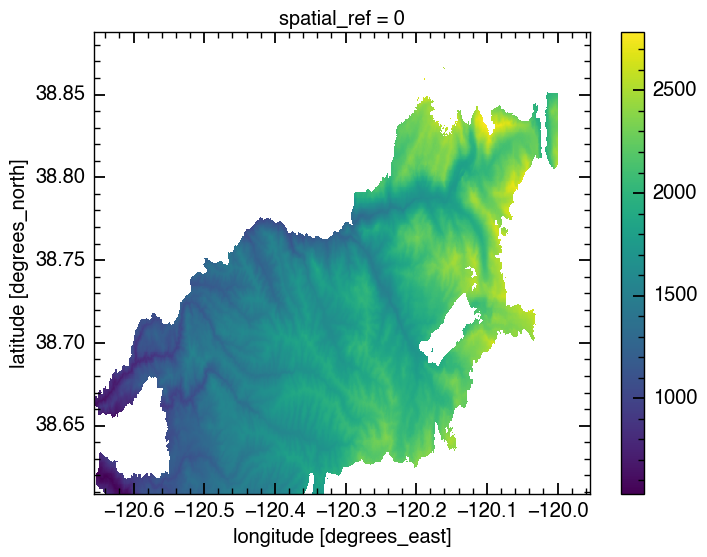

In [65]:
srtm_50.rio.clip(caldor.geometry, invert=False).plot()

'80-100'

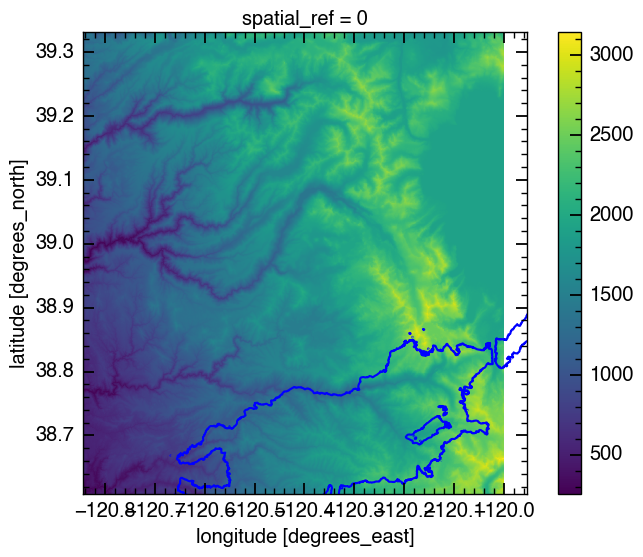

In [64]:
fig, ax = plt.subplots()
srtm_50.plot(ax=ax)
caldor.boundary.plot(ax=ax)
plt.show()

KeyError: '2023Jan31'

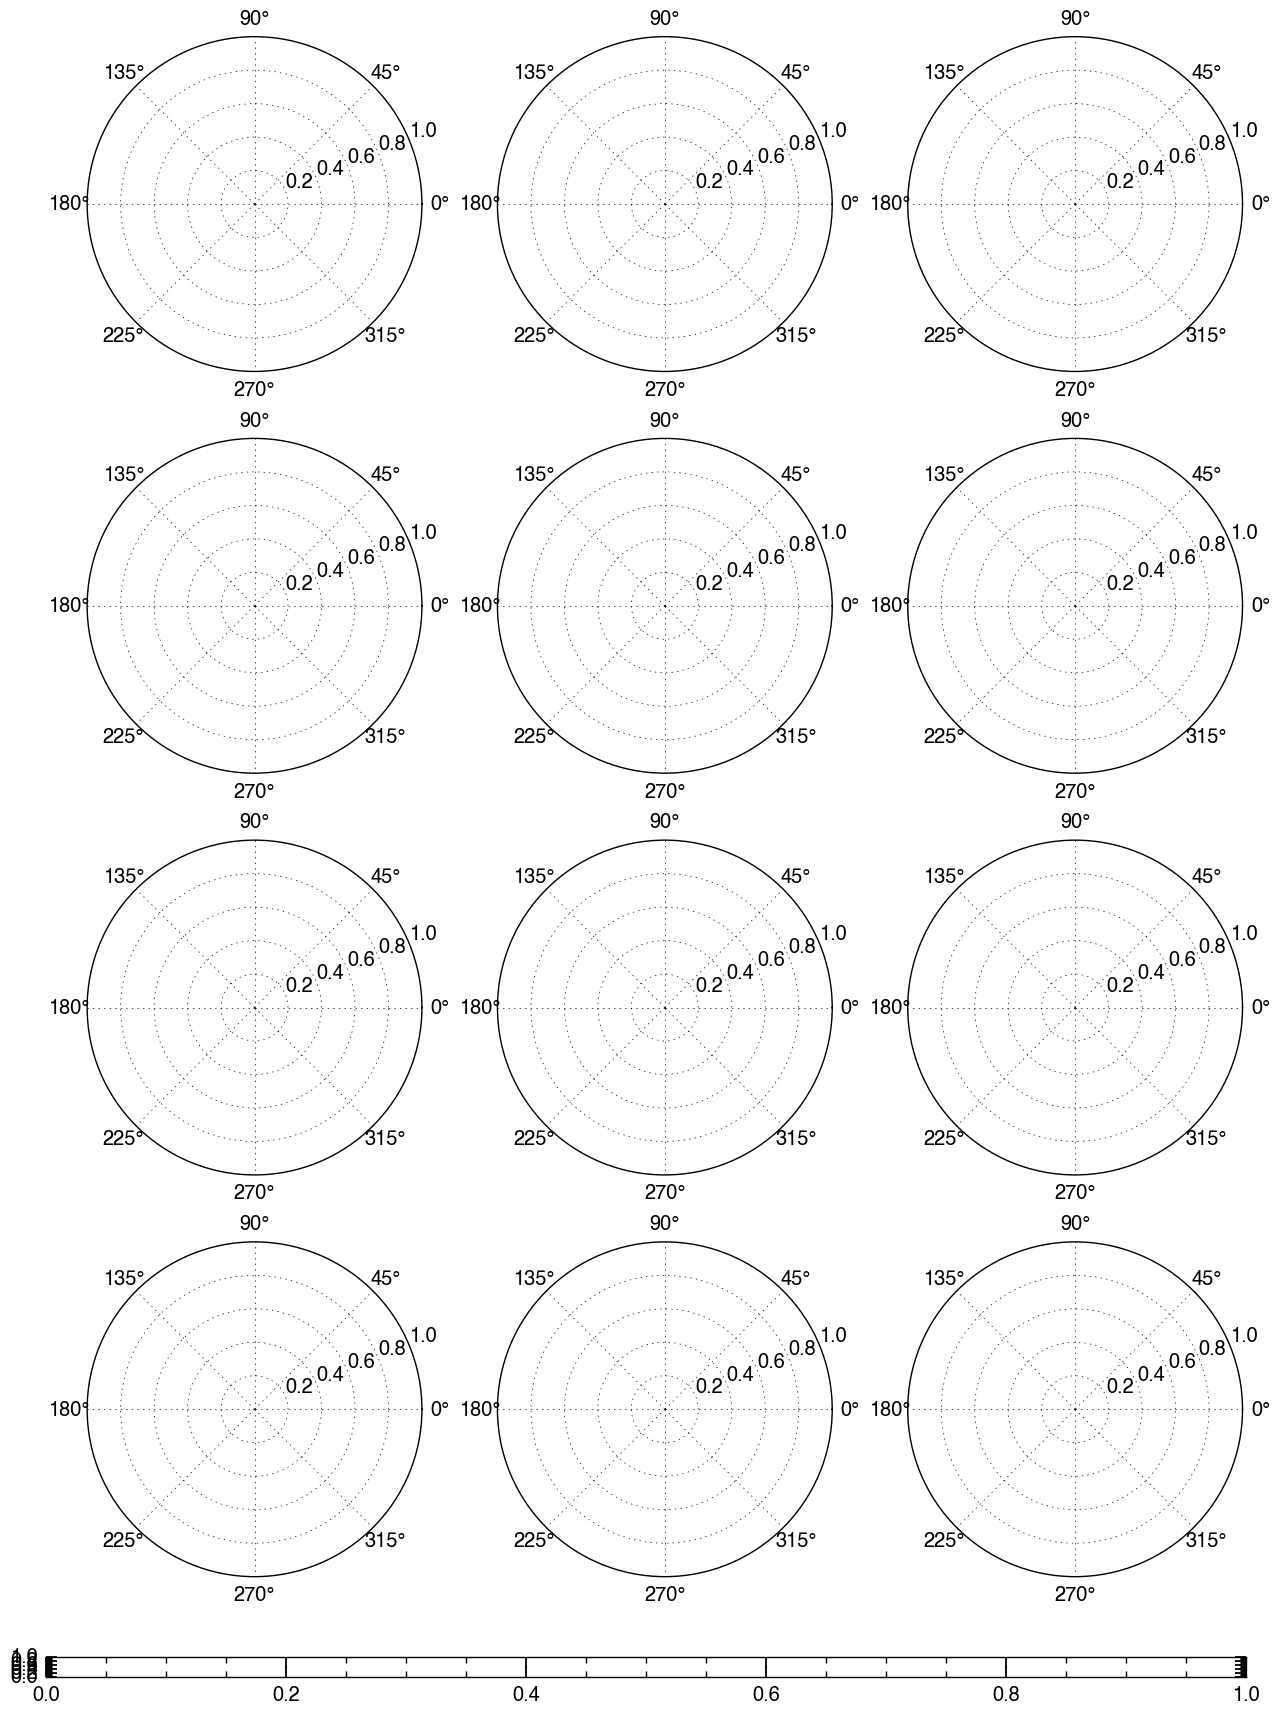

In [45]:
aspect_theta = np.radians(aspect_bands) + np.pi
cat1 = "80-100"
radii = elev_bands_depth
radii_m = elev_bands_depth * 0.3048
aspect_theta_2 = [0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
       3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
       5.89048623, 6.28318531]

fig, axs = plt.subplots(4,3, figsize=(15, 20), subplot_kw={'projection': 'polar'}) # ,gridspec_kw = {'height_ratios':[1, 1, 1, 1, 0.2]})
cbar_ax = fig.add_axes([0.1,0.06,0.8,0.01], ) # [left, bottom, width, height]
for id,date in enumerate(dates23):
    in_grids = category_grids_forest[date]
    
    axs[id,0].text(np.pi, 1600, f'{date[4:7]} {date[7:]}, {date[0:4]}', ha='center', va='center', fontsize=16, color='black', rotation = 90)
    
    for i, cat2 in enumerate(["0-20", "20-40", "40-60"]):
        ax = axs[id,i]
        # ax.contourf(aspect_theta, radii, np.isnan(in_grids[cat2] - in_grids[cat1] ), cmap='Greys', vmin=-1, vmax=1)
        data = in_grids[cat2] - in_grids[cat1]
        data2 = np.zeros((len(radii), len(aspect_theta_2)))
        data2[:,0:17] = data
        data2[:,16] = data[:,0]
        cb = ax.contourf(aspect_theta_2, radii_m ,data2, cmap='seismic_r',  levels = np.linspace(-2, 2, 20), extend = 'both')

        # cb = ax.contourf(aspect_theta, radii,data, cmap='seismic_r', vmin=-1, vmax=1, levels = np.linspace(-1, 1, 20), extend = 'both')

        ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
        ax.set_xticklabels(['E', 'N', 'W', 'S'])
        
        ax.set_yticks([1800, 2000, 2200, 2400, 2600])

        ax.set_ylim(2600, 1800)
        
        if id == 0:
            ax.set_title(cat2, pad = 30, loc='center')
            

new_ticks = [-1, -0.79, -0.58, -0.367, -0.158, 0, 0.158, 0.367, 0.58,  0.79, 1]
new_ticks = [v*2 for v in new_ticks]


cbar = fig.colorbar(cb, ticks=new_ticks,
                    cax=cbar_ax, orientation='horizontal', extend='both', label='Snow depth difference from unburned [m]')

for i,ax in enumerate(axs.flatten()):
    ax.text(0,.9,f'({chr(97+i)})', transform = ax.transAxes, weight = 'bold')
plt.savefig('../figures/elev-aspect-canopy-2023.jpg', dpi=800, bbox_inches='tight')
plt.show()


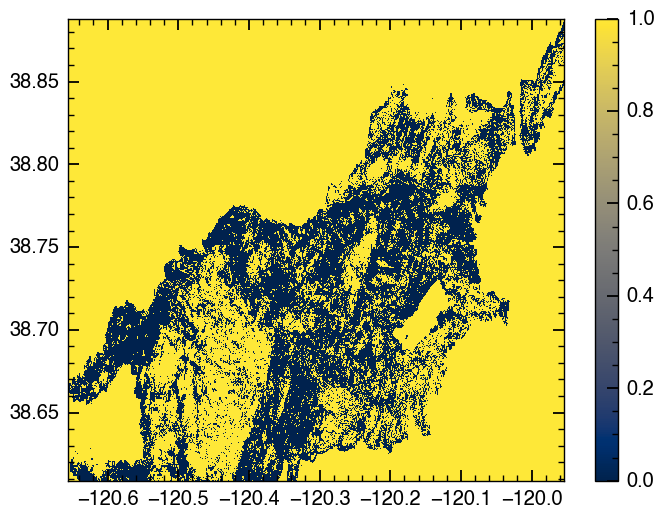

In [27]:
tmp = category_masks_forest['0-20'].rio.clip(caldor.geometry, invert=False)
fig, ax = plt.subplots()
cbar= ax.pcolormesh(tmp.x, tmp.y, tmp)
plt.colorbar(cbar)
plt.show()

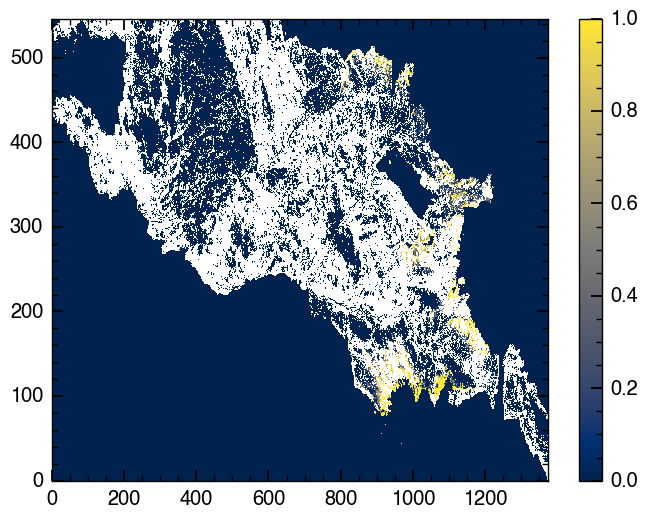

In [38]:
plt.pcolormesh(inside.where(tmp).sel(band=1), vmin =0, vmax = 1)
plt.colorbar()

In [39]:
tmp = inside.where(tmp).sel(band=1)

<xarray.DataArray (y: 546, x: 1373)>
array([[-9999., -9999., -9999., ..., -9999., -9999.,    nan],
       [-9999., -9999., -9999., ..., -9999., -9999.,    nan],
       [-9999., -9999., -9999., ..., -9999.,    nan,    nan],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -120.7 -120.7 -120.7 ... -120.0 -120.0 -120.0
  * y            (y) float64 38.89 38.89 38.89 38.89 ... 38.61 38.61 38.61 38.61
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0

In [ ]:


## make category_grids_canopy

category_grids_forest = {}
elev_bands_forest= {}

for i, date in enumerate(dates24 + dates23):
    category_grids_depth[date] = {}
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    inside = ds.rio.clip(caldor.geometry, invert=False)
    outside = ds.rio.clip(caldor.geometry, invert=True)
        
    for j, category in enumerate(categories):
        category_mask = category_masks[category]['band_data'][0].rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(category_mask)
        inside_category = inside_category.where(inside_category >= 0)  # Remove negative values
        aspect_50_in = aspect_50.aspect.rio.clip(caldor.geometry, invert=False).where(category_mask)
        srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert=False).where(category_mask)

        elev_bands_forest, aspect_bands_forest, elev_aspect_cat_forest, counts_in = get_elev_aspect_grid(inside_category, srtm_50_in, aspect_50_in, STATIC=True)
        category_grids_forest[date][category] = elev_aspect_cat
